In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
import sys

sys.path.insert(0, 'modules/')
    
from chromosome_data_processor import * 
from lengths_data_processor import *

In [3]:
data = pd.read_csv('datasets/CytoScan.Segmental.Reports/OS001_events.txt', sep='\t', comment='#')

In [4]:
data = process_chromosome_data(data)

data

,Chromosome,Copy Number,Length,Start,End
0,1,3,1961264,3699709,5660972
1,1,3,1898488,6923109,8821596
3,1,3,3223208,12392108,15615315
15,1,3,1522222,60470133,61992354
22,1,3,13965171,69521787,83486957
...,...,...,...,...,...
764,Y,3,90619,25623467,25714085
765,Y,3,36116,25789995,25826110
766,Y,3,185678,26147446,26333123
767,Y,3,392040,27012136,27404175


In [5]:
lengths = pd.read_csv('datasets/hs37d5.fa.fai', sep='\t', header=None)

In [6]:
lengths = process_lengths_data(lengths)

lengths

,Length
Chromosome,
1,249250621
2,243199373
3,198022430
4,191154276
5,180915260
6,171115067
7,159138663
8,146364022
9,141213431


In [7]:
def split_chromosome_to_bins(chromosome_data, chromosome_len, bin_len=30000):
    bins = []
    for base in range(0, chromosome_len, bin_len):
        if chromosome_len - base < bin_len:  # last short bin
            curr_bin_len = chromosome_len - base
        else:
            curr_bin_len = bin_len
            
        _bin = np.full((curr_bin_len), 2)
        
        bin_start = base
        bin_end = base + bin_len
        
        for index, row in chromosome_data.iterrows():
            event_start = int(row['Start'])
            event_end = int(row['End'])
            
            if event_start < bin_start and event_end >= bin_start:
                update_start = 0
                if event_end < bin_end:
                    update_end = event_end - bin_start + 1
                else:
                    update_end = bin_end
                _bin[update_start:update_end] = row['Copy Number']
                
            elif event_start <= bin_end and event_end >= bin_end:
                update_end = bin_end
                if event_start > bin_start:
                    update_start = event_start - bin_start + 1
                else:
                    update_start = 0
                _bin[update_start:update_end] = row['Copy Number']
                    
            elif event_start >= bin_start and event_end < bin_end:
                update_start = event_start - bin_start + 1
                update_end = event_end - bin_start + 1
                _bin[update_start:update_end] = row['Copy Number']
        
        bin_avg = np.average(_bin)
        bins.append(bin_avg)
    
    return bins

In [8]:
chr6 = data[data['Chromosome'] == '6']

chr6

,Chromosome,Copy Number,Length,Start,End
179,6,1,32969007,0,32969006
184,6,1,25136920,33023971,58160890
191,6,1,48000997,61000000,109000996
195,6,4,5939,109000996,109006934
198,6,1,62108134,109006934,171115067


In [9]:
chr6_len = lengths.loc[['6']]['Length'].item()

chr6_len

171115067

In [10]:
bins = split_chromosome_to_bins(chr6, chr6_len)

In [11]:
def plot_bins(bins):
    fig, ax = plt.subplots(figsize=(20,10))
    ax.plot(bins, color='k')
    ax.set_ylim([-0.5, 4.5])
    ax.set_xlim([0, len(bins)])

    ax.axhline(y=2, color='gray', dashes=(5, 5))

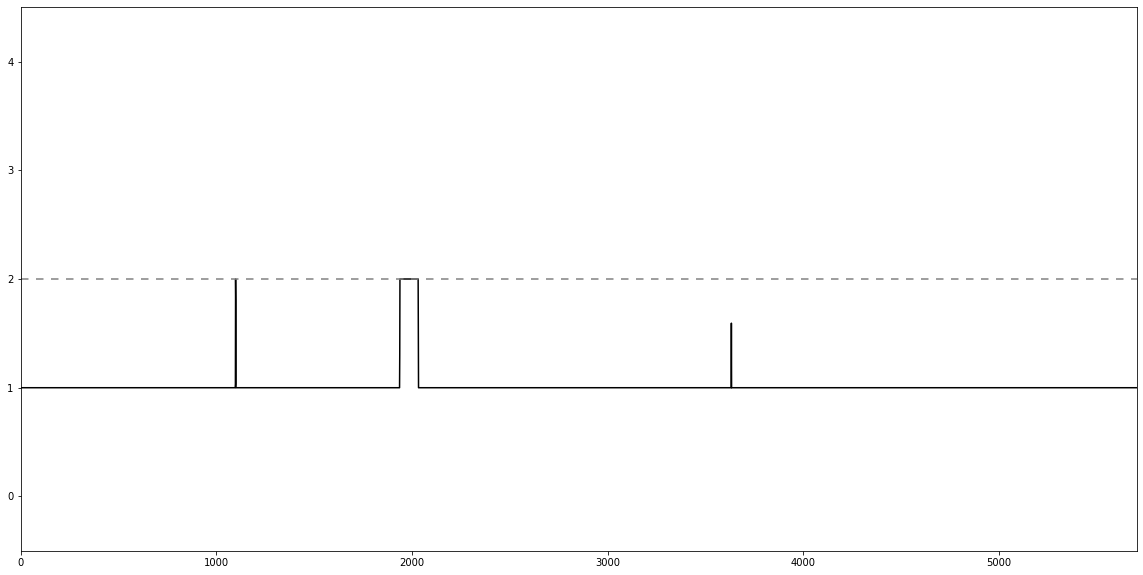

In [12]:
plot_bins(bins)

In [13]:
def scatter_bins(bins):
    fig, ax = plt.subplots(figsize=(25,10))
    ax.scatter(range(len(bins)), bins, c='k', s=8)
   
    ax.set_ylim([-0.5, 4.5])
    ax.set_xlim([0, len(bins)])

    ax.axhline(y=2, color='gray', dashes=(5, 5))

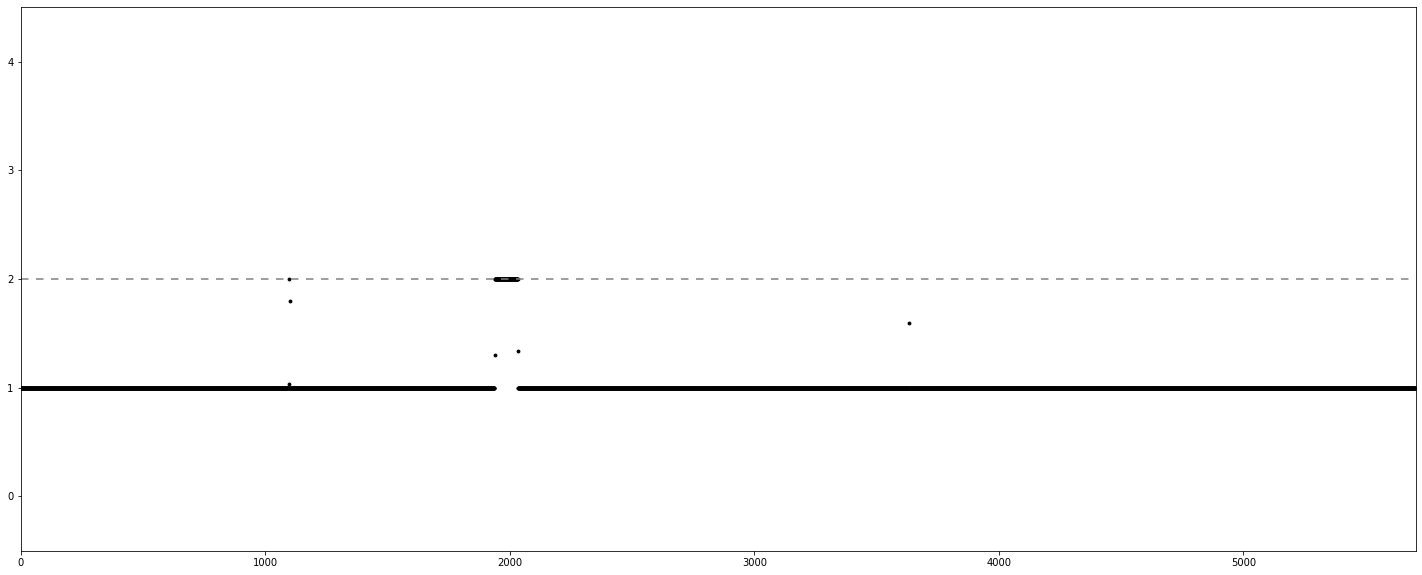

In [14]:
scatter_bins(bins)

In [15]:
chromosome_names = [str(_chr) for _chr in range(1, 23)]
chromosome_names.extend(['X', 'Y'])

chromosome_names

['1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 'X',
 'Y']

In [16]:
def split_chromosomes_to_bins(data):
    bins = []
    for _chr in chromosome_names[:-2]:
        chr_data = data[data['Chromosome'] == _chr]
        chr_len = lengths.loc[[_chr]]['Length'].item()
        chr_bins = split_chromosome_to_bins(chr_data, chr_len)
        bins.extend(chr_bins)
        
    return bins

In [17]:
bins = split_chromosomes_to_bins(data)

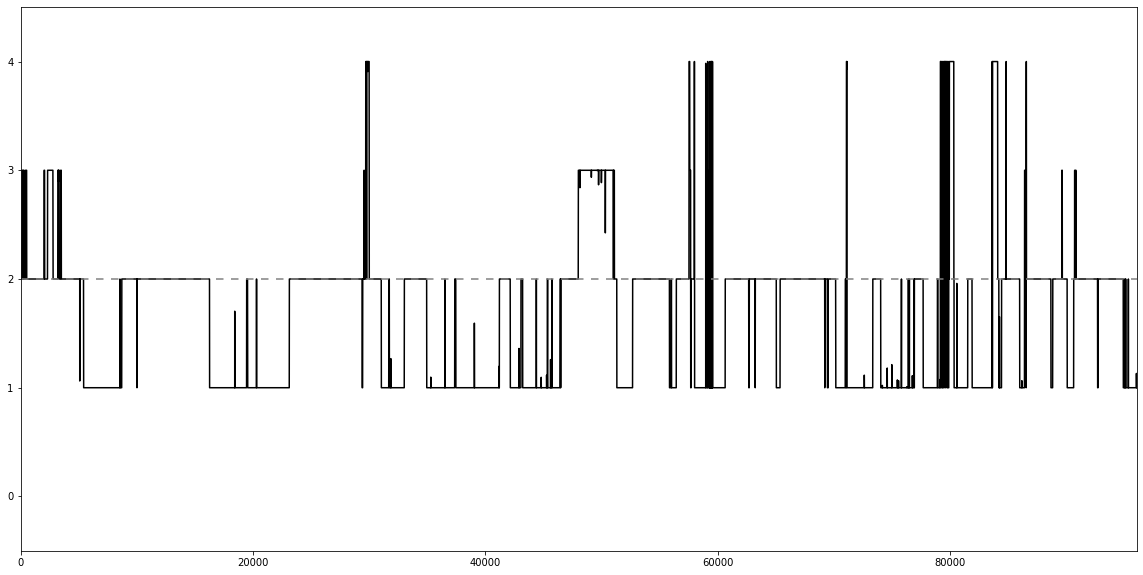

In [18]:
plot_bins(bins)

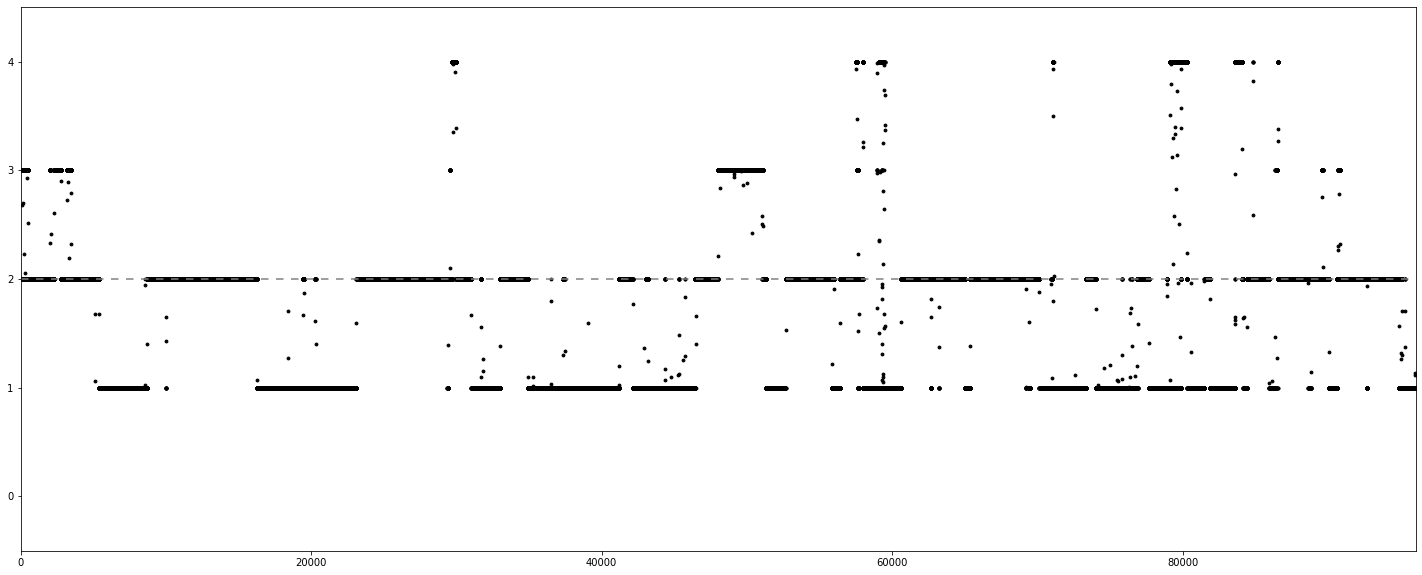

In [19]:
scatter_bins(bins)

In [20]:
def count_chromosome_area(chromosome_bins):
    area = 0
    for _bin in chromosome_bins:
        area += abs(_bin - 2)
        
    return area

In [21]:
chr6_bins = split_chromosome_to_bins(chr6, chr6_len)


In [22]:
chr6_area = count_chromosome_area(chr6_bins)

chr6_area

5606.937033333334

In [23]:
def count_chromosome_areas():
    areas = []
    for _chr in chromosome_names[:-2]:
        chr_data = data[data['Chromosome'] == _chr]
        chr_len = lengths.loc[[_chr]]['Length'].item()
        chr_bins = split_chromosome_to_bins(chr_data, chr_len)
        chr_area = count_chromosome_area(chr_bins)
        areas.append(chr_area)
        
    return areas

In [24]:
areas = count_chromosome_areas()

areas

[3811.8467333333333,
 557.4807666666666,
 6497.4726,
 106.40056666666666,
 3053.0037666666667,
 5606.937033333334,
 4199.945166666667,
 3100.6354999999994,
 1510.349,
 3292.0774333333325,
 154.81106666666668,
 404.0938,
 3186.6233,
 2845.543966666667,
 3375.7688333333335,
 2635.9119333333333,
 1514.8074666666669,
 524.8522666666667,
 751.4173666666667,
 95.7317,
 0.0,
 1115.5169]

In [25]:
len(areas)

22

In [26]:
def visualize_areas_bar(areas):
    fig, ax = plt.subplots(figsize=(20,10))
    ax.bar(chromosome_names[:-2], areas)
    ax.set_ylim([0, 7000])

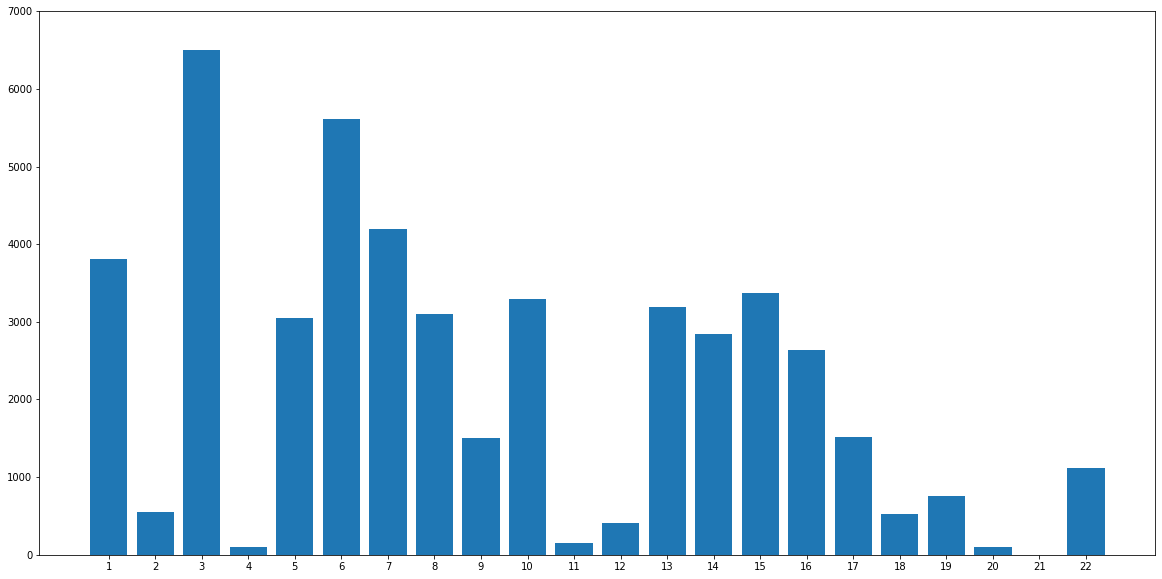

In [27]:
visualize_areas_bar(areas)

In [28]:
data2 = pd.read_csv('datasets/CytoScan.Segmental.Reports/OS007_events.txt', sep='\t', comment='#')

In [29]:
data2 = process_chromosome_data(data2)

data2

,Chromosome,Copy Number,Length,Start,End
0,1,3,35902120,0,35902119
7,1,4,50082064,36958762,87040825
16,1,4,17259570,87043855,104303424
23,1,4,13442894,104308161,117751054
28,1,4,3587817,117751501,121339317
...,...,...,...,...,...
775,X,3,469421,147322761,147792181
776,X,3,4337,147795632,147799968
777,X,3,449103,147800507,148249609
779,X,3,4853232,148301353,153154584


In [30]:
chr6_2 = data2[data2['Chromosome'] == '6']

chr6_2

,Chromosome,Copy Number,Length,Start,End
337,6,4,30676227,1179129,31855355
346,6,1,33445,32671461,32704905
355,6,3,17731023,41010475,58741497
360,6,3,1496579,61000000,62496578
363,6,4,363645,63073845,63437489
364,6,4,70579,71838860,71909438
370,6,4,36102758,92237248,128340005
375,6,4,18982781,128344631,147327411
378,6,4,23773816,147341252,171115067


In [31]:
bins2 = split_chromosomes_to_bins(data2)

In [41]:
from collections import Counter

In [42]:
def intersection(s1, s2) : 
  
    # Find the intersection of the two sets  
    intersect = list((Counter(s1) & Counter(s2)).elements())

    return intersect

In [46]:
def jaccard(chromosome_bins1, chromosome_bins2):
    # Sizes of both the sets  
    size1 = len(chromosome_bins1)
    size2 = len(chromosome_bins2)  
  
    # Get the intersection set  
    intersect = intersection(chromosome_bins1, chromosome_bins2)
  
    # Size of the intersection set  
    size_in = len(intersect)
  
    # Calculate the Jaccard index  
    # using the formula  
    jaccard_in = size_in  / (size1 + size2 - size_in)  
  
    # Return the Jaccard index  
    return jaccard_in

In [47]:
jaccard_in = jaccard(bins, bins2)

jaccard_in

0.2928641619664275

In [54]:
# example

a = [1,2,2,2,2]
b = [2,2,2,2,3]


intersect = list((Counter(a) & Counter(b)).elements())
intersect

jaccard_in = len(intersect)  / (len(a) + len(b) - len(intersect))
jaccard_in

0.6666666666666666